### Build A Basic Chatbot With Langgraph(Graph API)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". the `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwritting them)
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="qwen/qwen3-32b")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002596EAA0BC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002596EB7D760>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm=init_chat_model("groq:qwen/qwen3-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002596EBDC200>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002596EBDCA70>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)

## Adding Node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## Compile the graph
graph=graph_builder.compile()

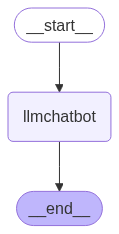

In [10]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({"messages":"Hi"})

In [12]:
response["messages"][-1].content

'<think>\nOkay, the user said "Hi". That\'s pretty open-ended. I should respond in a friendly and welcoming way. Maybe ask them how I can assist. Let me keep it simple and positive.\n\nI need to make sure my response is approachable. Something like "Hello! How can I assist you today?" should work. That invites them to share what they need help with. I\'ll go with that.\n</think>\n\nHello! How can I assist you today?'

In [13]:
for event in graph.stream({"messages":"Hi, How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

<think>
Okay, the user greeted me with "Hi, How are you?" which is a common friendly opener. I need to respond in a warm and engaging way. I should acknowledge their greeting and offer a cheerful reply. Let me make sure to keep the tone positive and approachable. Maybe something like "Hello! I'm doing well, thank you for asking! How about you?" That should cover it. It's friendly, shows appreciation for their concern, and opens the door for them to share their own status. I should check for any typos or errors before sending. Yep, looks good! Let's go ahead and send that response.
</think>

Hello! I'm doing well, thank you for asking! How about you? 😊


## Chatbot With Tool

In [14]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tools=[tool]
tool.invoke("What is Nasa?")

{'query': 'What is Nasa?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/NASA',
   'title': 'NASA - Wikipedia',
   'content': "an independent agency of the US federal government responsible for the United States's civil space program, aeronautics research and space research.",
   'score': 0.80844593,
   'raw_content': None},
  {'url': 'https://www.nasa.gov/learning-resources/for-kids-and-students/what-is-nasa-grades-5-8/',
   'title': 'What Is NASA? (Grades 5-8)',
   'content': 'Published Time: 2018-09-24T13:41:00-04:00 What Is NASA? (Grades 5-8) - NASA Recently Published NASA+ About NASA NASA+ 5 min read ### NASA’s Europa Clipper Captures Mars in Infrared article2 days ago 6 min read ### What NASA Is Learning from the Biggest Geomagnetic Storm in 20 Years article5 days ago 6 min read ### What’s Up: May 2025 Skywatching Tips from NASA article2 weeks ago The Sun Mars Dark Energy Dark Matter The Sun & Heliophysics ### Ab

In [15]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b
        
        Args:
            a (int): first int
            b (int): second int
        
        Returns:
            int: output int
    """
    return a*b

In [16]:
tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002596EBDC200>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002596EBDCA70>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

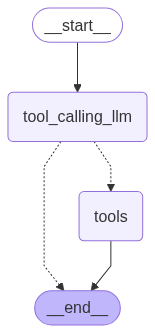

In [18]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is a not tool call -> tools_condition routes to end                      
    tools_condition)

builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [20]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": ["https://assets.weforum.org/editor/Ktdhn0KNfhbpY_AE77yZFRYJ9zUl9hnFcncbE53QzUQ.PNG", "https://blog.tipranks.com/wp-content/uploads/2023/03/shutterstock_1818555053-750x406.jpg", "https://wp.technologyreview.com/wp-content/uploads/2021/01/image001.jpg", "https://www.cio.com/wp-content/uploads/2021/12/artificial_intelligence_machine_learning_network_thinkstock_671750598-100724432-orig.jpeg?quality=50&strip=all", "https://www.uctoday.com/wp-content/uploads/2024/05/AI-Show-Analyzing-the-Latest-AI-News-and-Trends.jpg"], "results": [{"url": "https://www.cnn.com/2025/07/28/tech/china-global-ai-cooperation-organization-waic-hnk-spc", "title": "China pitches global AI governance group as the US goes it alone", "content": "More recently, another startup Moonshot’s Kimi K2 model released earlier this month also sent ripples in the AI community for its lower cost and capabilities that outperform some Google and Ope

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (68ak29bew)
 Call ID: 68ak29bew
  Args:
    include_images: True
    query: recent ai news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": ["https://assets.weforum.org/editor/Ktdhn0KNfhbpY_AE77yZFRYJ9zUl9hnFcncbE53QzUQ.PNG", "https://blog.tipranks.com/wp-content/uploads/2023/03/shutterstock_1818555053-750x406.jpg", "https://wp.technologyreview.com/wp-content/uploads/2021/01/image001.jpg", "https://www.cio.com/wp-content/uploads/2021/12/artificial_intelligence_machine_learning_network_thinkstock_671750598-100724432-orig.jpeg?quality=50&strip=all", "https://www.uctoday.com/wp-

In [22]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})

In [23]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (t5bwartp1)
 Call ID: t5bwartp1
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: general
  multiply (vs5h5w8tf)
 Call ID: vs5h5w8tf
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/news/computers_math/artificial_intelligence/", "title": "Artificial Intelligence News - ScienceDaily", "content": "ScienceDaily\n\n# Artificial Intelligence News\n\n## Top Headlines\n\n## Latest Headlines\n\n## Earlier Headlines\n\n### Tuesday, May 27, 2025\n\n### Thursday, May 22, 2025\n\n### Wednesday, May 21, 

### ReAct Agent Architecture

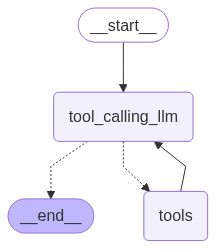

In [28]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is a not tool call -> tools_condition routes to end                      
    tools_condition)

builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (8pcmbzhfz)
 Call ID: 8pcmbzhfz
  Args:
    query: recent AI news
    time_range: week
    topic: news
  multiply (ppy2g8ds3)
 Call ID: ppy2g8ds3
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/category/artificial-intelligence/", "title": "AI News & Artificial Intelligence | TechCrunch", "content": "News coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today.", "score": 0.5423064, "raw_content": null}, {"url": "https://www.nbcnews.com/tech/tech-news/ai-models-can-

### Adding Memory In Agentic Graph

In [26]:
response=graph.invoke({"messages":"Hello my name is Ahmed"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Ahmed
================================== Ai Message ==================================

Hello Ahmed! How can I assist you today?


In [27]:
response=graph.invoke({"messages":"What is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't have access to personal information about users, including your name. My capabilities are limited to the tools provided, and none of the available functions can retrieve personal identity information. Would you like me to help with something else using the tools shown in the documentation?


In [29]:
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"Hi my name is Ahmed"},config=config)
response

{'messages': [HumanMessage(content='Hi my name is Ahmed', additional_kwargs={}, response_metadata={}, id='324b7fb4-50df-4074-bb4d-3d6107c1c282'),
  AIMessage(content='Hello Ahmed! 😊 How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "Hi my name is Ahmed." Let me think about how to respond.\n\nFirst, I need to acknowledge his greeting. A simple "Hello" seems appropriate. Then, I should mention his name to make it personal. Maybe add an emoji to keep it friendly. Also, I should offer assistance since he might have a question or need help. Let me check if there are any other tools I need to use here. The tools provided include Tavily Search and Multiply, but this is just a greeting, so no function calls are needed. Just a friendly response to start the conversation.\n'}, response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 1825, 'total_tokens': 1966, 'completion_time': 0.320765424, 'prompt_time': 0.079997646, 'queue_time': 

In [30]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)
print(response["messages"][-1].content)

Your name is Ahmed! 😊 How can I assist you today?


### Streaming

In [42]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [43]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

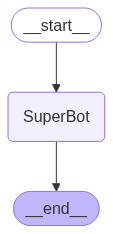

In [44]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)

## edge
graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile(checkpointer=memory)

## Display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [45]:
## Invocation
config={"configurable":{"thread_id":"1"}}
response = graph_builder.invoke({"messages":"Hi My name is Ahmed and i like cricket"},config=config)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Ahmed and i like cricket
================================== Ai Message ==================================

<think>
Okay, the user introduced himself as Ahmed and mentioned that he likes cricket. I should respond in a friendly and engaging way. First, I need to acknowledge his introduction and express that I'm pleasant to meet him. Then, since he likes cricket, I should ask him about his favorite team or player to keep the conversation going. Maybe also ask about what aspect of cricket he enjoys the most, like batting, bowling, or fielding. I should keep the questions open-ended to encourage him to share more. Also, I should make sure the tone is positive and enthusiastic. Let me structure the response step by step: start with a greeting, acknowledge his interest, ask about favorite team/player, and then ask about his favorite part of the game. That should cover the initial interaction and in

### Streaming
Methods: .stream() and astream()

- There methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This stream the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [54]:
# Create a thread
config={"configurable":{"thread_id":"2"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Ahmed and i like cricket"},config=config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="<think>\nOkay, the user introduced themselves again with the same message. They mentioned their name is Ahmed and they like cricket. Since the previous response was about getting more details about their cricket interest, maybe they want to continue the conversation.\n\nI should acknowledge their message again, maybe with a friendly reminder that we've already started talking. Let me make sure to keep the response positive and encouraging. Perhaps ask if there's something specific they want to discuss about cricket now. Maybe suggest topics like playing techniques, recent matches, or team news. Need to keep it open-ended so they can choose what they're interested in. Also, use emojis to keep the tone light and approachable. Let me check for any typos and ensure the response is welcoming.\n</think>\n\nHi again, Ahmed! 😊 I remember you mentioned you love cricket—what would you like to chat about today? Are you excited about any upcoming match

In [55]:
# Create a thread
config={"configurable":{"thread_id":"2"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Ahmed and i like cricket"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Ahmed and i like cricket', additional_kwargs={}, response_metadata={}, id='72a6715e-85b1-4aa2-8394-c8a48d5af5a5'), AIMessage(content="<think>\nOkay, the user is Ahmed, and he likes cricket. I need to respond in a friendly and engaging way. Let me start by greeting him and acknowledging his interest in cricket. Maybe ask him what position he plays or if he follows any particular team. But wait, the initial message is pretty short, so I shouldn't assume too much. Let me keep it open-ended. Also, make sure to use proper grammar and friendly emojis to keep the tone positive. Let me check for any possible follow-up questions he might have. Alright, I think that's a good start.\n</think>\n\nHi Ahmed! 👋 Nice to meet you! Cricket is an awesome sport—I’d love to hear more about what you enjoy about it. Do you play yourself, or are you more of a fan watching matches? Also, any favorite teams or players? 🏏😊", additional_kwargs={}, response_metada

In [56]:
# Create a thread
config={"configurable":{"thread_id":"2"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Ahmed and i also like football"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Ahmed and i like cricket', additional_kwargs={}, response_metadata={}, id='72a6715e-85b1-4aa2-8394-c8a48d5af5a5'), AIMessage(content="<think>\nOkay, the user is Ahmed, and he likes cricket. I need to respond in a friendly and engaging way. Let me start by greeting him and acknowledging his interest in cricket. Maybe ask him what position he plays or if he follows any particular team. But wait, the initial message is pretty short, so I shouldn't assume too much. Let me keep it open-ended. Also, make sure to use proper grammar and friendly emojis to keep the tone positive. Let me check for any possible follow-up questions he might have. Alright, I think that's a good start.\n</think>\n\nHi Ahmed! 👋 Nice to meet you! Cricket is an awesome sport—I’d love to hear more about what you enjoy about it. Do you play yourself, or are you more of a fan watching matches? Also, any favorite teams or players? 🏏😊", additional_kwargs={}, response_metada

In [57]:
# Create a thread
config={"configurable":{"thread_id":"3"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Ali and i like apple"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Ali and i like apple', additional_kwargs={}, response_metadata={}, id='28ddee82-f53c-4858-a589-00cea63603b0')]}
{'messages': [HumanMessage(content='Hi, My name is Ali and i like apple', additional_kwargs={}, response_metadata={}, id='28ddee82-f53c-4858-a589-00cea63603b0'), AIMessage(content='<think>\nOkay, the user introduced himself as Ali and mentioned he likes apples. I should acknowledge his introduction and express interest in his preference for apples. I can ask follow-up questions to engage in a more meaningful conversation. Maybe ask about his favorite type of apple or how he usually enjoys them. I should keep the tone friendly and open to encourage further interaction. Also, offer help if he needs anything else. Let me put that together in a natural way.\n</think>\n\nHi Ali! Nice to meet you. 🍎 I love that you like apples—they’re such a versatile and tasty fruit! What’s your favorite type of apple, or do you have a preferred w

In [58]:
# Create a thread
config={"configurable":{"thread_id":"3"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Ali and i also like banana"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Ali and i like apple', additional_kwargs={}, response_metadata={}, id='28ddee82-f53c-4858-a589-00cea63603b0'), AIMessage(content='<think>\nOkay, the user introduced himself as Ali and mentioned he likes apples. I should acknowledge his introduction and express interest in his preference for apples. I can ask follow-up questions to engage in a more meaningful conversation. Maybe ask about his favorite type of apple or how he usually enjoys them. I should keep the tone friendly and open to encourage further interaction. Also, offer help if he needs anything else. Let me put that together in a natural way.\n</think>\n\nHi Ali! Nice to meet you. 🍎 I love that you like apples—they’re such a versatile and tasty fruit! What’s your favorite type of apple, or do you have a preferred way to enjoy them (like eating them raw, in pies, or maybe even apple juice)? Let me know if you’d like to share more or need help with anything else! 😊', additiona

In [59]:
# Create a thread
config={"configurable":{"thread_id":"4"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Faizan and i like apple"},config=config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="<think>\nOkay, the user said his name is Faizan and he likes apples. I need to respond in a friendly way to both parts. First, greet him by name. Then, talk about apples in a positive way. Maybe add an emoji related to apples. Keep it simple and warm.\n\nLet me make sure to acknowledge both pieces of information clearly.\n</think>\n\nHello, Faizan! 🍎 It's great to meet you. I love that you like apples—they're such a delicious and healthy choice! Crunchy, juicy, or even in a pie? 😊 What's your favorite way to enjoy them?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 20, 'total_tokens': 149, 'completion_time': 0.350896305, 'prompt_time': 0.000551003, 'queue_time': 0.006311905, 'total_time': 0.351447308}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0f1dcefc-561a-4ec1-aa9c-cba329b0e

In [60]:
# Create a thread
config={"configurable":{"thread_id":"4"}}
for chunk in graph_builder.stream({"messages":"Hi, My name is Faizan and i also like mango"},config=config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='<think>\nOkay, the user is Faizan and he mentioned liking both apples and mangoes. I need to respond in a friendly way. Let me start by acknowledging his name again. He already mentioned apples before, so now adding mangoes. Maybe compare apples and mangoes a bit? Highlight the sweetness of mangoes versus apples. Ask him which he prefers more. Also, check if he likes them fresh or in other forms like smoothies or desserts. Keep the tone cheerful and engaging. Use emojis to make it more lively. Make sure the response is concise but covers all the points. Let me put that together.\n</think>\n\nHello again, Faizan! 🍊🍎 Wow, apples *and* mangoes? That’s like having the best of both worlds—crunchy vs. sweet, classic vs. tropical! 🌴 Do you prefer mangoes fresh, in a smoothie, or maybe as a dessert? I’d love to hear which one you like more, or if you’re a "both, and I can’t choose" kind of person! 😄', additional_kwargs={}, response_metadata={'token

In [63]:
# Create a thread
config={"configurable":{"thread_id":"4"}}
async for chunk in graph_builder.astream_events({"messages":"Hi, My name is Ali and i like to play gaming"},config,version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, My name is Ali and i like to play gaming'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '045675d7-15bd-4659-81e1-10a652ca2604', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is Faizan and i like apple', additional_kwargs={}, response_metadata={}, id='0f06c55a-8858-48c7-b3ed-672a5df40d46'), AIMessage(content="<think>\nOkay, the user said his name is Faizan and he likes apples. I need to respond in a friendly way to both parts. First, greet him by name. Then, talk about apples in a positive way. Maybe add an emoji related to apples. Keep it simple and warm.\n\nLet me make sure to acknowledge both pieces of information clearly.\n</think>\n\nHello, Faizan! 🍎 It's great to meet you. I love that you like apples—they're such a delicious and healthy choice! Crunchy, juicy, or even in a pie? 😊 What's your favorite way to enjoy them?", 